In [10]:
import pickle
import numpy as np
import pyGMs as gm
import time
import pandas as pd

In [11]:
with open('user_dict.pkl','rb') as f:
    user_dict = pickle.load(f)
with open('train_users.pkl','rb') as f:
    train_users = pickle.load(f)
with open('test_users.pkl','rb') as f:
    test_users = pickle.load(f)

LIKE_THRESHOLD = 4
n_movies = next(iter(user_dict.values())).shape[0]

In [12]:
def build_matrix(uids):
    M = np.empty((len(uids), n_movies), dtype=float)
    M[:] = np.nan
    for i, uid in enumerate(uids):
        M[i] = user_dict[uid]
    return M

def binarize(X):
    return np.where(
        np.isnan(X),
        np.nan,
        (X >= LIKE_THRESHOLD).astype(int)
    )

In [13]:
Xtr = build_matrix(train_users)
Xte = build_matrix(test_users)

Xtrb = binarize(Xtr)
Xteb = binarize(Xte)

Xtr_full = np.nan_to_num(Xtrb, nan=0).astype(int)
Xte_full = np.nan_to_num(Xteb, nan=0).astype(int)

In [14]:
counts = np.sum(~np.isnan(Xtrb), axis=0)
sums   = np.nansum(Xtrb, axis=0)
p_i = np.divide(
    sums,
    counts,
    out=np.full_like(sums, 0.5),
    where=(counts > 0)
)

factors = [gm.Factor([gm.Var(i,2)], [1-p_i[i], p_i[i]]) for i in range(n_movies)]
model0 = gm.GraphModel(factors, isLog=True)

In [ ]:
def conditional(factor, i, x):
    return factor.t[tuple(
        x[v] if v != i else slice(v.states)
        for v in factor.vars
    )]

def pseudolikelihood(model, X, eps=1e-12):
    N, M = X.shape
    LL   = np.zeros((N, M))
    for i in range(M):
        flist = model.factorsWith(i, copy=False)
        for j in range(N):
            pXi = 1.0
            for f in flist:
                pXi = pXi * conditional(f, i, X[j])
            pXi = pXi + eps
            total = pXi.sum()
            LL[j, i] = np.log(pXi[X[j, i]] / total)
    return LL.sum(axis=1)

In [16]:
sizes   = [50, 100, 500, 1000, 2500, len(train_users)]
results = []

for sz in sizes:
    subset_train = train_users[:sz]
    Xtr   = build_matrix(subset_train)
    Xtrb  = binarize(Xtr)
    Xtr_f = np.nan_to_num(Xtrb, nan=0).astype(int)

    Xte   = build_matrix(test_users)
    Xteb  = binarize(Xte)
    Xte_f = np.nan_to_num(Xteb, nan=0).astype(int)

    t0 = time.time()
    counts = np.sum(~np.isnan(Xtrb), axis=0)
    sums   = np.nansum(Xtrb, axis=0)
    p_i = np.divide(
        sums,
        counts,
        out=np.full_like(sums, 0.5),
        where=(counts > 0)
    )
    factors = [
        gm.Factor([gm.Var(i,2)], [1-p_i[i], p_i[i]])
        for i in range(n_movies)
    ]
    model0 = gm.GraphModel(factors, isLog=True)
    train_time_s = time.time() - t0

    train_pll = pseudolikelihood(model0, Xtr_f).mean()

    t1 = time.time()
    test_pll = pseudolikelihood(model0, Xte_f).mean()
    pred_time_s = time.time() - t1

    preds     = (p_i >= 0.5).astype(int)
    preds_mat = np.tile(preds, (Xte_f.shape[0], 1))
    mask      = ~np.isnan(Xteb)
    accuracy  = (preds_mat[mask] == Xte_f[mask]).mean()

    results.append({
        'train_size':             sz,
        'train_time_s':           train_time_s,
        'pred_time_s':            pred_time_s,
        'accuracy':               accuracy,
        'train_pseudolikelihood': train_pll,
        'test_pseudolikelihood':  test_pll
    })

In [17]:
df = pd.DataFrame(
    results,
    columns=[
        'train_size',
        'train_time_s',
        'pred_time_s',
        'accuracy',
        'train_pseudolikelihood',
        'test_pseudolikelihood'
    ]
)

df

,train_size,train_time_s,pred_time_s,accuracy,train_pseudolikelihood,test_pseudolikelihood
0,50,0.217837,13.129139,0.639760,-14363.215657,-14855.247619
1,100,0.350637,12.825927,0.658951,-11910.493297,-12155.023741
2,500,0.385663,12.263075,0.678251,-6373.169988,-6420.537574
3,1000,0.304853,12.363247,0.681912,-5311.234156,-5333.175819
4,2500,0.382086,12.335043,0.684399,-4751.292944,-4760.558360
5,5040,0.425599,12.469213,0.685604,-4191.115293,-4197.952524


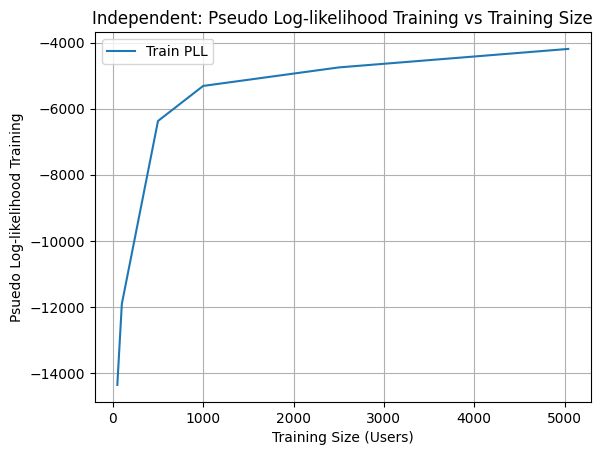

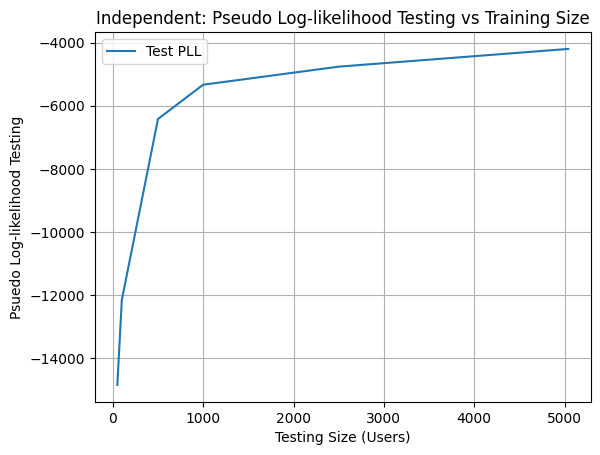

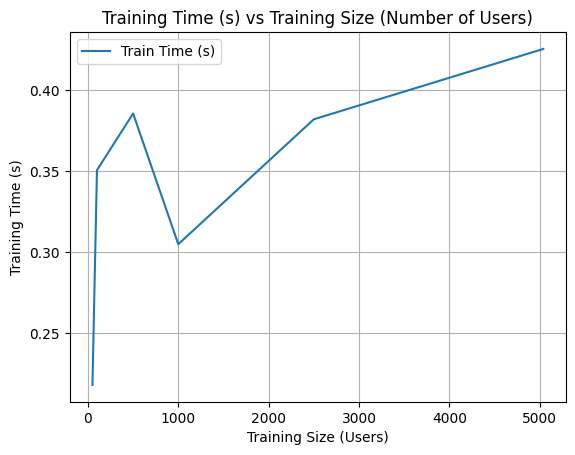

In [25]:
import matplotlib.pyplot as plt

sizes = df['train_size']

plt.figure()
plt.plot(sizes, df['train_pseudolikelihood'], label='Train PLL')
plt.title("Independent: Pseudo Log-likelihood Training vs Training Size")
plt.xlabel("Training Size (Users)")
plt.ylabel("Psuedo Log-likelihood Training")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(sizes, df['test_pseudolikelihood'], label='Test PLL')
plt.title("Independent: Pseudo Log-likelihood Testing vs Training Size")
plt.xlabel("Testing Size (Users)")
plt.ylabel("Psuedo Log-likelihood Testing")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(sizes, df['train_time_s'], label='Train Time (s)')
plt.title("Training Time (s) vs Training Size (Number of Users)")
plt.xlabel("Training Size (Users)")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.legend()
plt.show()